In [9]:
#from openpyxl import Workbook, load_workbook
import os
import glob
!pip install pandas
!pip install numpy
from IPython import get_ipython
import pandas as pd
import numpy as np
from functools import partial
import sys
from ipywidgets import widgets
sys.path.append('E:\2- Professional\OneDrive - Siemens AG\Trash\OpenPyXL')

## Split Verification Tool - Hossam Abdel All
This tool is intended to verify whether a certain plan for a given intersection warrants closer investigation due to certain intersection configuration. The input is the directory where a single or multiple files are desired to be processed. The output is a simple print statement, colorized for clarity. This print output can be exported as a pdf.
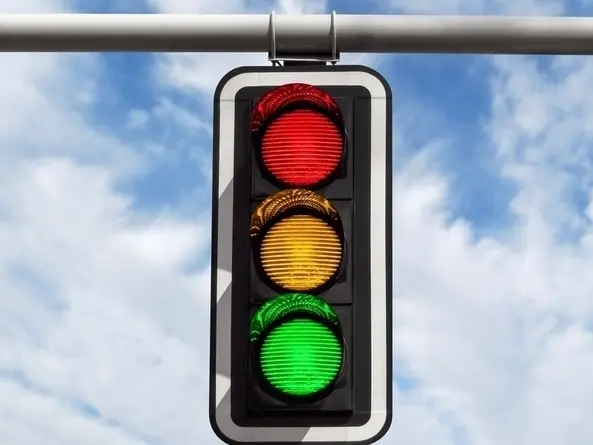

In [12]:
#defining class for formatting
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [38]:
#getting path name
#pathName = input('what is the path to your files?')
pathName = widgets.Text()
instructions = widgets.HTML('Enter file directory:')
display(instructions)
display(pathName)


HTML(value='Enter file directory:')

Text(value='')

In [39]:
pathName.value

'E:\\2- Professional\\Coding Projects\\OpenPyXL\\data\\Polygon 7 - 2'

In [40]:
#to get a list of all files under that directory
filenames = glob.glob(pathName.value + "\*.xls")
#print('File names:', filenames)

In [16]:
#iterate over each file to perform the process
for file in filenames:
    # copy the pages needed
    raw_data = pd.read_excel(file, sheet_name= 'Raw Data')
    split_data = pd.read_excel(file, sheet_name= 'Calculated Split Times')
    split_data = pd.read_excel(file, sheet_name= 'Calculated Split Times')
    split_data_patt = split_data.iloc[12:55, 0:21]
    split_data_min = split_data.iloc[3:11, 12:14]
    split_data_min
    #split_data = split_data.iloc[14:55, 0:21]
    pattern_data = raw_data.iloc[7:24, 32:34]
    pattern_data = raw_data.iloc[[7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],[32,33,34,35]]
    pattern_data = pattern_data.rename(columns=pattern_data.iloc[0]).drop(pattern_data.index[0]) #dropping the unnamed header
    pattern_data = pattern_data.apply(pd.to_numeric) #converting from object to integer
    pattern_data_peak = pattern_data.loc[(pattern_data['DOW'] == 124) & (pattern_data['Hour'].between(5.0,7.0) | pattern_data['Hour'].between(14.0,16.0))] #approximating peak patterns 
    pattern_data_peak_lst = pattern_data_peak['Plan/Offset'].tolist()
    pattern_data_peak_lst = list(map(int, pattern_data_peak_lst))
    print(color.BOLD + color.UNDERLINE + color.DARKCYAN+ str(split_data.iloc[9:11, 1].values) + color.END)
    if pattern_data_peak.empty:
        print("This asset runs Free 24/7")
    # generating the ring_structure
    ring = raw_data.iloc[[46,47,48,49,50,51,52,53,], [0,1]]
    #ring = ring.rename(columns=ring.iloc[0]).drop(ring.index[0])
    phase = [1,2,3,4,5,6,7,8]
    ring['phase'] = phase
    ring = ring[['SN1','phase']].apply(pd.to_numeric)
    ring_dict = ring.set_index('phase').T.to_dict('list')
    #splitting into two rings
    split_idx = 4
    ring_1_dict = dict(list(ring_dict.items())[:split_idx])
    ring_2_dict = dict(list(ring_dict.items())[split_idx:])
    u = ring_2_dict[7]
    m = ring_2_dict[8]

    # Generating correct Ring Structure: checking for empty phases on Ring 1 while Ring 2 has phases
    if ring_1_dict[3] == [0] and ring_2_dict[7] != [0]:
        ring_1_dict.pop(3, None)
        ring_1_dict.update({7:u})
        ring_2_dict.pop(7, None)
    if (ring_1_dict[4] == [0] and ring_2_dict[8] != [0]):
        ring_1_dict.pop(4, None)
        ring_1_dict.update({8:m})
        ring_2_dict.pop(8, None)
    ring_1_last = list(ring_1_dict)[-1]
    ring_2_last = list(ring_2_dict)[-1]
    ring_1_first = list(ring_1_dict)[0]
    fing_2_first = list(ring_2_dict)[0]

    #finding side street phase values from the Split Times sheet for all Peak Patterns
    for pat in pattern_data_peak_lst:
        print(color.BOLD + 'Pattern #: ' + str(pat) + color.END)
        if pat != 62:
            patt_num_loc= split_data_patt[split_data_patt== pat].dropna(axis=0, how='all').dropna(axis=1, how='all') #finding where that pattern is in the Calculated Split sheet
            row_num_patt = patt_num_loc.index.values[0]-12 #which row is it in? We're subtracting 12 since the index started at 12
            col_num_patt = split_data_patt.columns.get_loc(patt_num_loc.columns.values[0]) #which column is it in?
            ring_1_dict_last = list(ring_1_dict.keys())[-1] #determining the last phase in each ring
            ring_2_dict_last = list(ring_2_dict.keys())[-1]
            side_st = [3,4,7,8] #the potential side street phases
            row_pos_last = {3:5,4:6, 7:9, 8:10} #defining the relative row position for each potential side street phases 4,7,8
            print('Last Phase in Ring 1: ' + str(ring_1_dict_last))
            print('Last Phase in Ring 2: ' + str(ring_2_dict_last))
            if ring_1_dict[1][0] != 0 :
                phs_1_min = split_data_min.iloc[(0,1)]
                phs_1_split = split_data_patt.iloc[row_num_patt+3, col_num_patt + 1]
                if any([a == ring_1_dict_last for a in side_st]):
                    ring_1_row_pos_last = row_pos_last[ring_1_dict_last]
                    phs_sd_st_r1 = split_data_patt.iloc[row_num_patt+ring_1_row_pos_last, col_num_patt + 1]
                    if phs_sd_st_r1 > 25:
                        prct_LT = (phs_1_split - phs_1_min)/phs_1_split
                        if prct_LT < 0.5:
                            print('Peak Pattern ' + str(pat) + ' does not meet criteria. The difference between pattern programmed split and min splits is ' + str(prct_LT) +' for phase 1 which is < 50%')
                        else:
                            print('Peak Pattern ' + color.BOLD + color.RED + str(pat) + ' meets the established criteria.'+color.END +' Phs 1 difference:' + str(prct_LT), 'Observe TACTICS Cycle MOE report')
                    else:
                        print('Peak Pattern ' + str(pat) + ' does not meet criteria. Ring 1 Side Street split is less than 25s')
                else:
                    print('Peak Pattern ' + str(pat) + ' does not meet criteria. No Ring 1 side street movements.')
            elif ring_2_dict[5][0] != 0 :
                phs_5_min = split_data_min.iloc[(4,1)]
                phs_5_split = split_data_patt.iloc[row_num_patt+7, col_num_patt + 1]
                if any([a == ring_2_dict_last for a in side_st]):
                    ring_2_row_pos_last = row_pos_last[ring_2_dict_last]
                    phs_sd_st_r2 = split_data_patt.iloc[row_num_patt+ring_2_row_pos_last, col_num_patt + 1]
                    if phs_sd_st_r2 > 25:
                        prct_LT = (phs_5_split - phs_5_min)/phs_5_split
                        if prct_LT < 0.5:
                            print('Peak Pattern ' + str(pat) + ' does not meet criteria. The difference between pattern programmed split and min splits is ' + str(prct_LT) +' for phase 5 which is < 50%')
                        else:
                            print('Peak Pattern ' +color.UNDERLINE+ color.BOLD + color.RED + str(pat) + ' meets the established criteria.' + color.END + 'Phs 5 difference:' + str(prct_LT), 'Observe TACTICS Cycle MOE report')
                    else:
                        print('Peak Pattern ' +  str(pat) + ' does not meet criteria. Ring 2 Side Street split is less than 25s')

                else:
                    print('Peak Pattern ' + str(pat) + ' does not meet criteria. No Ring 2 side street movements.')


            else:
                print('Peak Pattern ' + str(pat) + ' does not meet criteria. There exists no potential impact to R2 Left Turn.')
        else:
            print('Pattern 62 is a Free Pattern. Does not meet criteria.')
    print()




['SR- 826 & NE 35 Av' 3671]
Pattern #: 7
Last Phase in Ring 1: 4
Last Phase in Ring 2: 8
Peak Pattern 7 does not meet criteria. Ring 1 Side Street split is less than 25s
Pattern #: 9
Last Phase in Ring 1: 4
Last Phase in Ring 2: 8
Peak Pattern 9 does not meet criteria. Ring 1 Side Street split is less than 25s

['Collins Av & SR- 856' 4606]
Pattern #: 1
Last Phase in Ring 1: 4
Last Phase in Ring 2: 8
Peak Pattern 1 does not meet criteria. Ring 2 Side Street split is less than 25s
Pattern #: 12
Last Phase in Ring 1: 4
Last Phase in Ring 2: 8
Peak Pattern 12 does not meet criteria. Ring 2 Side Street split is less than 25s



In [520]:
split_data_patt

,Pattern data conversion from BiTrans forceoff point to SEPAC split times,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
12,Plan,1,NaN,2,NaN,3,NaN,4,NaN,5,...,6,NaN,7,NaN,8,NaN,9,NaN,10,NaN
13,NaN,BiTrans,SEPAC,BiTrans,SEPAC,BiTrans,SEPAC,BiTrans,SEPAC,BiTrans,...,BiTrans,SEPAC,BiTrans,SEPAC,BiTrans,SEPAC,BiTrans,SEPAC,BiTrans,SEPAC
14,Cycle Length,120,120,120,120,130,130,120,120,0,...,90,90,120,120,110,110,120,120,110,110
15,Phase 1 - ForceOff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,Phase 2 - ForceOff,0,95,0,95,0,105,0,95,0,...,0,65,0,95,0,85,0,95,0,85
17,Phase 3 - ForceOff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,Phase 4 - ForceOff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,Phase 5 - ForceOff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,Phase 6 - ForceOff,0,95,0,95,0,105,0,95,0,...,0,65,0,95,0,85,0,95,0,85
21,Phase 7 - ForceOff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [517]:
ring_2_dict

{5: [0], 6: [2], 7: [0]}

In [526]:
 for pat in pattern_data_peak_lst:
        print('Pattern #: ' + str(pat))
        if pat != 62:
            patt_num_loc= split_data_patt[split_data_patt== pat].dropna(axis=0, how='all').dropna(axis=1, how='all') #finding where that pattern is in the Calculated Split sheet
            row_num_patt = patt_num_loc.index.values[0]-12 #which row is it in? We're subtracting 12 since the index started at 12
            col_num_patt = split_data_patt.columns.get_loc(patt_num_loc.columns.values[0]) #which column is it in?
            ring_1_dict_last = list(ring_1_dict.keys())[-1] #determining the last phase in each ring
            ring_2_dict_last = list(ring_2_dict.keys())[-1]
            side_st = [3,4,7,8] #the potential side street phases
            row_pos_last = {3:5,4:6, 7:9, 8:10} #defining the relative row position for each potential side street phases 4,7,8
            print('Last Phase in Ring 1: ' + str(ring_1_dict_last))
            if ring_1_dict[1][0] != 0 :
                phs_1_min = split_data_min.iloc[(0,1)]
                phs_1_split = split_data_patt.iloc[row_num_patt+3, col_num_patt + 1]
                if any([a == ring_1_dict_last for a in side_st]):
                    ring_1_row_pos_last = row_pos_last[ring_1_dict_last]
                    phs_sd_st_r1 = split_data_patt.iloc[row_num_patt+ring_1_row_pos_last, col_num_patt + 1]
                    if phs_sd_st_r1 > 25:
                        prct_LT = (phs_1_split - phs_1_min)/phs_1_split
                        if prct_LT < 0.5:
                            print('Peak Pattern ' + str(pat) + ' does not meet criteria. The difference between pattern programmed split and min splits is ' + str(prct_LT) +' for phase 1 which is < 50%')
                        else:
                            print('Peak Pattern ' + str(pat) + ' meets the established criteria. Phs 1 difference:' + str(prct_LT), 'Observe TACTICS Cycle MOE report')
                    else:
                        print('Peak Pattern ' + str(pat) + ' does not meet criteria. Ring 1 Side Street split is less than 25s')
                else:
                    print('Peak Pattern ' + str(pat) + ' does not meet criteria. No Ring 1 side street movements.')
            elif ring_2_dict[5][0] != 0 :
                phs_5_min = split_data_min.iloc[(4,1)]
                phs_5_split = split_data_patt.iloc[row_num_patt+7, col_num_patt + 1]
                if any([a == ring_2_dict_last for a in side_st]):
                    ring_2_row_pos_last = row_pos_last[ring_2_dict_last]
                    phs_sd_st_r2 = split_data_patt.iloc[row_num_patt+ring_2_row_pos_last, col_num_patt + 1]
                    if phs_sd_st_r2 > 25:
                        prct_LT = (phs_5_split - phs_5_min)/phs_5_split
                        if prct_LT < 0.5:
                            print('Peak Pattern ' + str(pat) + ' does not meet criteria. The difference between pattern programmed split and min splits is ' + str(prct_LT) +' for phase 5 which is < 50%')
                        else:
                            print('Peak Pattern ' + str(pat) + ' meets the established criteria. Phs 5 difference:' + str(prct_LT), 'Observe TACTICS Cycle MOE report')
                    else:
                        print('Peak Pattern ' + str(pat) + ' does not meet criteria. Ring 2 Side Street split is less than 25s')
                
                else:
                    print('Peak Pattern ' + str(pat) + ' does not meet criteria. No Ring 2 side street movements.')

            
            else:
                print('Peak Pattern ' + str(pat) + ' does not meet criteria. There exists no potential impact to R2 Left Turn.')
        else:
            print('Pattern 62 is a Free Pattern. Does not meet criteria.')
        print()
    

    

Pattern #: 1
Last Phase in Ring 1: 8
Peak Pattern 1 does not meet criteria. There exists no potential impact to R2 Left Turn.

Pattern #: 12
Last Phase in Ring 1: 8
Peak Pattern 12 does not meet criteria. There exists no potential impact to R2 Left Turn.



In [524]:
split_data_min

,Unnamed: 12,Unnamed: 13
3,Phase 1,1
4,Phase 2,23
5,Phase 3,1
6,Phase 4,1
7,Phase 5,1
8,Phase 6,23
9,Phase 7,1
10,Phase 8,4


In [52]:
os.path.dirname(sys.executable)

'C:\\Users\\hossa\\anaconda3'

In [69]:
!pip install watermark

In [77]:

import watermark
%load_ext watermark

# python, ipython, packages, and machine characteristics
%watermark -v -m -p pandas,numpy,watermark 

# date
print (" ")
%watermark -u -n -t -z 

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

pandas   : 1.4.4
numpy    : 1.21.5
watermark: 2.3.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit

 
Last updated: Sun Jan 15 2023 00:57:41Eastern Standard Time



In [81]:
from platform import python_version
print(python_version())
pd. __version__

3.9.13


'1.4.4'

In [37]:
filenames

['E:\\2- Professional\\Coding Projects\\OpenPyXL\\data\\Polygon 8\\3454_US-1& NE 187 St_NEW_Complete.xls',
 'E:\\2- Professional\\Coding Projects\\OpenPyXL\\data\\Polygon 8\\3776_DB_Export_Complete.xls',
 'E:\\2- Professional\\Coding Projects\\OpenPyXL\\data\\Polygon 8\\3965_SW 127 Av&SW 47 St_Complete.xls',
 'E:\\2- Professional\\Coding Projects\\OpenPyXL\\data\\Polygon 8\\4299_Aventura Blvd&NE 29 Pl_Complete_NEW_.xls',
 'E:\\2- Professional\\Coding Projects\\OpenPyXL\\data\\Polygon 8\\4301_US 1&NE 209 St_Complete_NEW_.xls',
 'E:\\2- Professional\\Coding Projects\\OpenPyXL\\data\\Polygon 8\\4586_SW 132 Av&SW 47 St_Complete.xls',
 'E:\\2- Professional\\Coding Projects\\OpenPyXL\\data\\Polygon 8\\4603_NE 26 Av&NE 203 St_Complete_NEW_.xls',
 'E:\\2- Professional\\Coding Projects\\OpenPyXL\\data\\Polygon 8\\4610_DB_Export_Complete.xls',
 'E:\\2- Professional\\Coding Projects\\OpenPyXL\\data\\Polygon 8\\4648_Aventura Blvd&Country Club Dr W_Complete.xls',
 'E:\\2- Professional\\Coding Proje